In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import shutil
import seaborn as sn
from os import listdir, walk, getcwd, mkdir
from os.path import isfile, join, sep
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# import resizing snippets
from conversion import *

In [2]:
# Create a fresh SVM subdirectory structure below
# If SVM or any of SVM subdirectory exists, then it removes the SVM subdirectory and create a new SVM folder with the structure below
# 
# +---.ipynb_checkpoints
# +---data
# |   \---Coronahack-Chest-XRay-Dataset
# |       \---Coronahack-Chest-XRay-Dataset
# |           +---SVM
# |           |   +---test_modified
# |           |   +---test_unique
# |           |   +---train_modified
# |           |   \---train_unique
# |           +---test
# |           \---train
# \---__pycache__


dir_path = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths = ["test_modified","train_modified","test_unique","train_unique"]

i = 0
loop_count = 0
while i < 4:
    loop_count += 1
    if loop_count == 7:
        break
    try:
        path = dir_path + '/SVM/' + subpaths[i]
        os.mkdir(path)
    except FileExistsError:
        # if folder exist then try remove the whole SVM subdirectory
        print("Directory " , 'SVM/' + subpaths[i] ,  " already exists")
        try:
            shutil.rmtree(dir_path + '/SVM/')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))
    except OSError:
        print ("Creation of the directory %s failed" % subpaths[i])
        path = dir_path + '/SVM/'
        os.mkdir(path)
    else:
        print ("Successfully created the directory %s " % subpaths[i])
        i += 1

Directory  SVM/test_modified  already exists
Creation of the directory test_modified failed
Successfully created the directory test_modified 
Successfully created the directory train_modified 
Successfully created the directory test_unique 
Successfully created the directory train_unique 


In [3]:
# Show metadata of dataset

filename = "data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
# create dict mapping image names to labels

label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [5]:
def collect_files(path, subpaths, label = False):
    """Collate paths of files (images)
    
    Args:
        path (type = string): the folder path of the images
        subpath (type = list): subdirectories of paths
        labels (type = boolean): collate corresponding labels for images. Default to False

    Returns:
        tuple (f,l) where:
            f (type = list): List of filepaths
            l (type = list): List of corresponding labels to f
    """
    f=[]
    l=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
                if label == True:
                    l.append(label_dict[file][0])
            break
    return f,l

In [6]:
def shape_rgb_or_grey(img):
    """number of rows, columns and transform image channels to string
    
    Args:
        img (image): image
    Returns:
        list (shp[0], shp[1], color) where:
        shp[0] (type = int): number of rows
        shp[1] (type = int): number of columns 
        color (type = string): img channel type (RGB or GREY)
    """
    
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''Statistical summary of element of a list of filepath (f)
    
    Args:
        f (type = list): list of image filepaths
    Returns:
        list (df_sizes, bad_images) where:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
        bad_images (type = list): images not found in meta_df (Chest_xray_Corona_Metadata)  
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]


# visualize distribution of image sizes
def df_size_plots(df_sizes):
    
    '''Plots heat map of file height and with and a histogram of image channels
    
    Args:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
    '''
    
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
--> 1-s2.0-S0929664620300449-gr3_lrg-a.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-b.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-c.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-d.jpg is not in metadata. Skipping.
--> 191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg is not in metadata. Skipping.
--> 21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg is not in metadata. Skipping.
--> 396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg is not in metadata. Skipping.
--> 3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg is not in metadata. Skipping.
--> 5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg is not in metadata. Skipping.
--> 66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg is not in metadata. Skipping.
--> 6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg is not in metadata. Skipping.
--> 925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg is not in metadata. Skipping.
--> DE488FE1-0C44-428B-B67A-0974

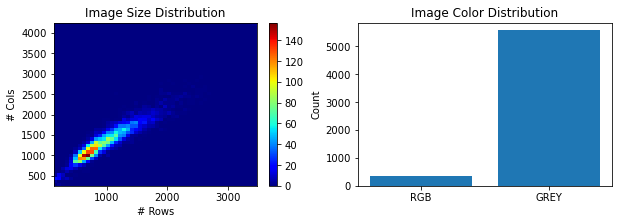

In [7]:
# Plotting the distribution of image sizes and channels in the train and test directory

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)
row_mean = df_sizes.n_rows.mean()
col_mean = df_sizes.n_cols.mean()

In [8]:
# Run conversion script on images in the train and test subdirectories.
# Save converted images to test_modified and train_modified subdirectories
# The conversion script rescales the largest dimension (width or length) of the image to 595 while preservating aspect ratio.
# Rotate each images by 10 degrees counterclockwise.
# Zero pad image so resulting dimension is 600 x 600
# Only images with metadata are converted and saved

RESIZE_BOOL = False # Originally True
ROWS = int(row_mean/2) # Does nothing since RESIZE_BOOL is False
COLS = int(col_mean/2) # Does nothing since RESIZE_BOOL is False
           
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["test","train"]
dest_subpaths = ["SVM/test_modified","SVM/train_modified"]

for i in range(len(source_subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    # Same as simulation #1. 7th input variable set to True. 8th input variable set to 10. 
    convert_image(test_path,test_destination_path,COLS,ROWS,RESIZE_BOOL,False,True,10,False,50,1,False,0.2,False,0.2,True,600,True,595,label_dict,print_every=200)

200 files processed out of 624 files.
400 files processed out of 624 files.
600 files processed out of 624 files.
--- There were 0 images without labels ---
200 files processed out of 5309 files.
400 files processed out of 5309 files.
600 files processed out of 5309 files.
800 files processed out of 5309 files.
1000 files processed out of 5309 files.
1200 files processed out of 5309 files.
1400 files processed out of 5309 files.
1600 files processed out of 5309 files.
1800 files processed out of 5309 files.
2000 files processed out of 5309 files.
2200 files processed out of 5309 files.
2400 files processed out of 5309 files.
2600 files processed out of 5309 files.
2800 files processed out of 5309 files.
3000 files processed out of 5309 files.
3200 files processed out of 5309 files.
3400 files processed out of 5309 files.
3600 files processed out of 5309 files.
3800 files processed out of 5309 files.
4000 files processed out of 5309 files.
4200 files processed out of 5309 files.
4400 fi

--- Parsing 5910 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed
--- There were 0 images not included in the metadata .csv ---


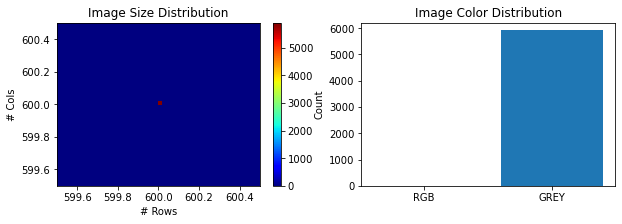

In [9]:
# Plotting the distribution of image sizes and channels for converted images.

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["SVM/test_modified","SVM/train_modified"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [10]:
# Pick one converted image per subject.
# Save the picked images in test_unique and train_unique subdirectories

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["SVM/test_modified","SVM/train_modified"]
dest_subpaths = ["SVM/test_unique","SVM/train_unique"]

for i in range(len(subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    list_unique_x_ray(test_path,test_destination_path,False,True,True)

1 files processed out of 415 files.
2 files processed out of 415 files.
3 files processed out of 415 files.
4 files processed out of 415 files.
5 files processed out of 415 files.
6 files processed out of 415 files.
7 files processed out of 415 files.
8 files processed out of 415 files.
9 files processed out of 415 files.
10 files processed out of 415 files.
11 files processed out of 415 files.
12 files processed out of 415 files.
13 files processed out of 415 files.
14 files processed out of 415 files.
15 files processed out of 415 files.
16 files processed out of 415 files.
17 files processed out of 415 files.
18 files processed out of 415 files.
19 files processed out of 415 files.
20 files processed out of 415 files.
21 files processed out of 415 files.
22 files processed out of 415 files.
23 files processed out of 415 files.
24 files processed out of 415 files.
25 files processed out of 415 files.
26 files processed out of 415 files.
27 files processed out of 415 files.
28 files p

221 files processed out of 415 files.
222 files processed out of 415 files.
223 files processed out of 415 files.
224 files processed out of 415 files.
225 files processed out of 415 files.
226 files processed out of 415 files.
227 files processed out of 415 files.
228 files processed out of 415 files.
229 files processed out of 415 files.
230 files processed out of 415 files.
231 files processed out of 415 files.
232 files processed out of 415 files.
233 files processed out of 415 files.
234 files processed out of 415 files.
235 files processed out of 415 files.
236 files processed out of 415 files.
237 files processed out of 415 files.
238 files processed out of 415 files.
239 files processed out of 415 files.
240 files processed out of 415 files.
241 files processed out of 415 files.
242 files processed out of 415 files.
243 files processed out of 415 files.
244 files processed out of 415 files.
245 files processed out of 415 files.
246 files processed out of 415 files.
247 files pr

58 files processed out of 2700 files.
59 files processed out of 2700 files.
60 files processed out of 2700 files.
61 files processed out of 2700 files.
62 files processed out of 2700 files.
63 files processed out of 2700 files.
64 files processed out of 2700 files.
65 files processed out of 2700 files.
66 files processed out of 2700 files.
67 files processed out of 2700 files.
68 files processed out of 2700 files.
69 files processed out of 2700 files.
70 files processed out of 2700 files.
71 files processed out of 2700 files.
72 files processed out of 2700 files.
73 files processed out of 2700 files.
74 files processed out of 2700 files.
75 files processed out of 2700 files.
76 files processed out of 2700 files.
77 files processed out of 2700 files.
78 files processed out of 2700 files.
79 files processed out of 2700 files.
80 files processed out of 2700 files.
81 files processed out of 2700 files.
82 files processed out of 2700 files.
83 files processed out of 2700 files.
84 files pro

287 files processed out of 2700 files.
288 files processed out of 2700 files.
289 files processed out of 2700 files.
290 files processed out of 2700 files.
291 files processed out of 2700 files.
292 files processed out of 2700 files.
293 files processed out of 2700 files.
294 files processed out of 2700 files.
295 files processed out of 2700 files.
296 files processed out of 2700 files.
297 files processed out of 2700 files.
298 files processed out of 2700 files.
299 files processed out of 2700 files.
300 files processed out of 2700 files.
301 files processed out of 2700 files.
302 files processed out of 2700 files.
303 files processed out of 2700 files.
304 files processed out of 2700 files.
305 files processed out of 2700 files.
306 files processed out of 2700 files.
307 files processed out of 2700 files.
308 files processed out of 2700 files.
309 files processed out of 2700 files.
310 files processed out of 2700 files.
311 files processed out of 2700 files.
312 files processed out o

516 files processed out of 2700 files.
517 files processed out of 2700 files.
518 files processed out of 2700 files.
519 files processed out of 2700 files.
520 files processed out of 2700 files.
521 files processed out of 2700 files.
522 files processed out of 2700 files.
523 files processed out of 2700 files.
524 files processed out of 2700 files.
525 files processed out of 2700 files.
526 files processed out of 2700 files.
527 files processed out of 2700 files.
528 files processed out of 2700 files.
529 files processed out of 2700 files.
530 files processed out of 2700 files.
531 files processed out of 2700 files.
532 files processed out of 2700 files.
533 files processed out of 2700 files.
534 files processed out of 2700 files.
535 files processed out of 2700 files.
536 files processed out of 2700 files.
537 files processed out of 2700 files.
538 files processed out of 2700 files.
539 files processed out of 2700 files.
540 files processed out of 2700 files.
541 files processed out o

743 files processed out of 2700 files.
744 files processed out of 2700 files.
745 files processed out of 2700 files.
746 files processed out of 2700 files.
747 files processed out of 2700 files.
748 files processed out of 2700 files.
749 files processed out of 2700 files.
750 files processed out of 2700 files.
751 files processed out of 2700 files.
752 files processed out of 2700 files.
753 files processed out of 2700 files.
754 files processed out of 2700 files.
755 files processed out of 2700 files.
756 files processed out of 2700 files.
757 files processed out of 2700 files.
758 files processed out of 2700 files.
759 files processed out of 2700 files.
760 files processed out of 2700 files.
761 files processed out of 2700 files.
762 files processed out of 2700 files.
763 files processed out of 2700 files.
764 files processed out of 2700 files.
765 files processed out of 2700 files.
766 files processed out of 2700 files.
767 files processed out of 2700 files.
768 files processed out o

964 files processed out of 2700 files.
965 files processed out of 2700 files.
966 files processed out of 2700 files.
967 files processed out of 2700 files.
968 files processed out of 2700 files.
969 files processed out of 2700 files.
970 files processed out of 2700 files.
971 files processed out of 2700 files.
972 files processed out of 2700 files.
973 files processed out of 2700 files.
974 files processed out of 2700 files.
975 files processed out of 2700 files.
976 files processed out of 2700 files.
977 files processed out of 2700 files.
978 files processed out of 2700 files.
979 files processed out of 2700 files.
980 files processed out of 2700 files.
981 files processed out of 2700 files.
982 files processed out of 2700 files.
983 files processed out of 2700 files.
984 files processed out of 2700 files.
985 files processed out of 2700 files.
986 files processed out of 2700 files.
987 files processed out of 2700 files.
988 files processed out of 2700 files.
989 files processed out o

1190 files processed out of 2700 files.
1191 files processed out of 2700 files.
1192 files processed out of 2700 files.
1193 files processed out of 2700 files.
1194 files processed out of 2700 files.
1195 files processed out of 2700 files.
1196 files processed out of 2700 files.
1197 files processed out of 2700 files.
1198 files processed out of 2700 files.
1199 files processed out of 2700 files.
1200 files processed out of 2700 files.
1201 files processed out of 2700 files.
1202 files processed out of 2700 files.
1203 files processed out of 2700 files.
1204 files processed out of 2700 files.
1205 files processed out of 2700 files.
1206 files processed out of 2700 files.
1207 files processed out of 2700 files.
1208 files processed out of 2700 files.
1209 files processed out of 2700 files.
1210 files processed out of 2700 files.
1211 files processed out of 2700 files.
1212 files processed out of 2700 files.
1213 files processed out of 2700 files.
1214 files processed out of 2700 files.


1421 files processed out of 2700 files.
1422 files processed out of 2700 files.
1423 files processed out of 2700 files.
1424 files processed out of 2700 files.
1425 files processed out of 2700 files.
1426 files processed out of 2700 files.
1427 files processed out of 2700 files.
1428 files processed out of 2700 files.
1429 files processed out of 2700 files.
1430 files processed out of 2700 files.
1431 files processed out of 2700 files.
1432 files processed out of 2700 files.
1433 files processed out of 2700 files.
1434 files processed out of 2700 files.
1435 files processed out of 2700 files.
1436 files processed out of 2700 files.
1437 files processed out of 2700 files.
1438 files processed out of 2700 files.
1439 files processed out of 2700 files.
1440 files processed out of 2700 files.
1441 files processed out of 2700 files.
1442 files processed out of 2700 files.
1443 files processed out of 2700 files.
1444 files processed out of 2700 files.
1445 files processed out of 2700 files.


1635 files processed out of 2700 files.
1636 files processed out of 2700 files.
1637 files processed out of 2700 files.
1638 files processed out of 2700 files.
1639 files processed out of 2700 files.
1640 files processed out of 2700 files.
1641 files processed out of 2700 files.
1642 files processed out of 2700 files.
1643 files processed out of 2700 files.
1644 files processed out of 2700 files.
1645 files processed out of 2700 files.
1646 files processed out of 2700 files.
1647 files processed out of 2700 files.
1648 files processed out of 2700 files.
1649 files processed out of 2700 files.
1650 files processed out of 2700 files.
1651 files processed out of 2700 files.
1652 files processed out of 2700 files.
1653 files processed out of 2700 files.
1654 files processed out of 2700 files.
1655 files processed out of 2700 files.
1656 files processed out of 2700 files.
1657 files processed out of 2700 files.
1658 files processed out of 2700 files.
1659 files processed out of 2700 files.


1841 files processed out of 2700 files.
1842 files processed out of 2700 files.
1843 files processed out of 2700 files.
1844 files processed out of 2700 files.
1845 files processed out of 2700 files.
1846 files processed out of 2700 files.
1847 files processed out of 2700 files.
1848 files processed out of 2700 files.
1849 files processed out of 2700 files.
1850 files processed out of 2700 files.
1851 files processed out of 2700 files.
1852 files processed out of 2700 files.
1853 files processed out of 2700 files.
1854 files processed out of 2700 files.
1855 files processed out of 2700 files.
1856 files processed out of 2700 files.
1857 files processed out of 2700 files.
1858 files processed out of 2700 files.
1859 files processed out of 2700 files.
1860 files processed out of 2700 files.
1861 files processed out of 2700 files.
1862 files processed out of 2700 files.
1863 files processed out of 2700 files.
1864 files processed out of 2700 files.
1865 files processed out of 2700 files.


2054 files processed out of 2700 files.
2055 files processed out of 2700 files.
2056 files processed out of 2700 files.
2057 files processed out of 2700 files.
2058 files processed out of 2700 files.
2059 files processed out of 2700 files.
2060 files processed out of 2700 files.
2061 files processed out of 2700 files.
2062 files processed out of 2700 files.
2063 files processed out of 2700 files.
2064 files processed out of 2700 files.
2065 files processed out of 2700 files.
2066 files processed out of 2700 files.
2067 files processed out of 2700 files.
2068 files processed out of 2700 files.
2069 files processed out of 2700 files.
2070 files processed out of 2700 files.
2071 files processed out of 2700 files.
2072 files processed out of 2700 files.
2073 files processed out of 2700 files.
2074 files processed out of 2700 files.
2075 files processed out of 2700 files.
2076 files processed out of 2700 files.
2077 files processed out of 2700 files.
2078 files processed out of 2700 files.


2266 files processed out of 2700 files.
2267 files processed out of 2700 files.
2268 files processed out of 2700 files.
2269 files processed out of 2700 files.
2270 files processed out of 2700 files.
2271 files processed out of 2700 files.
2272 files processed out of 2700 files.
2273 files processed out of 2700 files.
2274 files processed out of 2700 files.
2275 files processed out of 2700 files.
2276 files processed out of 2700 files.
2277 files processed out of 2700 files.
2278 files processed out of 2700 files.
2279 files processed out of 2700 files.
2280 files processed out of 2700 files.
2281 files processed out of 2700 files.
2282 files processed out of 2700 files.
2283 files processed out of 2700 files.
2284 files processed out of 2700 files.
2285 files processed out of 2700 files.
2286 files processed out of 2700 files.
2287 files processed out of 2700 files.
2288 files processed out of 2700 files.
2289 files processed out of 2700 files.
2290 files processed out of 2700 files.


2479 files processed out of 2700 files.
2480 files processed out of 2700 files.
2481 files processed out of 2700 files.
2482 files processed out of 2700 files.
2483 files processed out of 2700 files.
2484 files processed out of 2700 files.
2485 files processed out of 2700 files.
2486 files processed out of 2700 files.
2487 files processed out of 2700 files.
2488 files processed out of 2700 files.
2489 files processed out of 2700 files.
2490 files processed out of 2700 files.
2491 files processed out of 2700 files.
2492 files processed out of 2700 files.
2493 files processed out of 2700 files.
2494 files processed out of 2700 files.
2495 files processed out of 2700 files.
2496 files processed out of 2700 files.
2497 files processed out of 2700 files.
2498 files processed out of 2700 files.
2499 files processed out of 2700 files.
2500 files processed out of 2700 files.
2501 files processed out of 2700 files.
2502 files processed out of 2700 files.
2503 files processed out of 2700 files.


2689 files processed out of 2700 files.
2690 files processed out of 2700 files.
2691 files processed out of 2700 files.
2692 files processed out of 2700 files.
2693 files processed out of 2700 files.
2694 files processed out of 2700 files.
2695 files processed out of 2700 files.
2696 files processed out of 2700 files.
2697 files processed out of 2700 files.
2698 files processed out of 2700 files.
2699 files processed out of 2700 files.
2700 files processed out of 2700 files.


In [12]:
def hog_descriptor(f_paths,image = False): 
    
    '''Computes Histogram of Oriented Gradients 
    
    Args:
        f_path (type = list): list of image filepaths
        image (type = bool/list): True to capture hod image array for ALL images, list to capature only the indexes in the list
    Returns:
        tuple (hog_fd, img_dict) where:
        hog_fd (type = list): hog feature description 
        img_dict (type = list): hog image  
    '''
    
    hog_fd = []
    img_dict = {}
    i = 0
    print_every = 500
        
    for filename in f_paths:
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
    
            img = imread(filename)
            try:
                if ((image == True) or (i in image)):
                    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt=True, block_norm="L1", visualize=True)
                    hog_fd.append(fd)
                    img_dict[i]= hog_image                
                else:
                    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt= True, block_norm="L1")
                    hog_fd.append(fd)

                
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except:
                print("Unknown exception occurred.") 
            
        else:
            print("Skipping {}.".format(filename))
            
    return(hog_fd, img_dict)

In [13]:
subpaths = ["SVM/train_unique"]

f_train,label_train = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in training set
hog_train, img_train = hog_descriptor(f_train,[1,2,3]) 

-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed


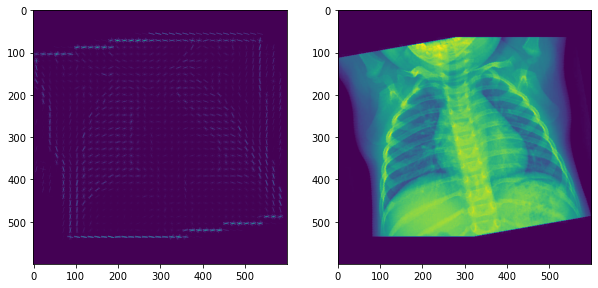

In [15]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_train = imread(f_train[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_train[2]/img_train[2].max()) 
ax[1].imshow(ex_img_train)

In [16]:
subpaths = ["SVM/test_unique"]

f_test, label_test = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in test set
hog_test, img_test = hog_descriptor(f_test, [2,3])

-> 0 images parsed


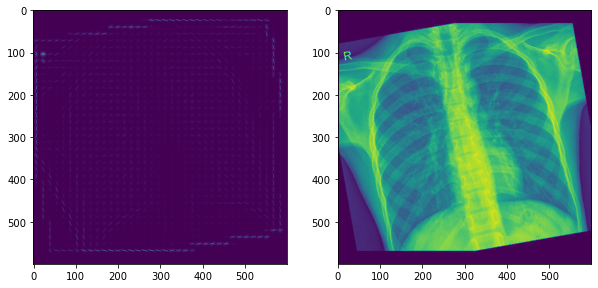

In [18]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_test = imread(f_test[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_test[2]/img_test[2].max()) 
ax[1].imshow(ex_img_test)

In [19]:
def data_stack(hog_fd,label):
    ''' Creates  array of hog descriptors and a flattened array of their corresponding labels

    Args:
        hog_fd (type = list): list of hog feature description 
        label (list): list of labels of hog_fd
    Returns:
        tuple (X, y) where:
        X (type = array): stacked hog feature description in hog_fd  
        y (type = array): flattened array of labels of hog_fd 
    '''
    label =  np.array(label).reshape(len(label),1)
    hog_fd = np.array(hog_fd)

    x,y = hog_fd,label.ravel()
    return (x,y)

In [20]:
# Preprocessed training and test set

x_train,y_train = data_stack(hog_train,label_train)
x_test,y_test = data_stack(hog_test,label_test)

In [22]:
# Standardize data
# fit support vector classifier with the polynomial kernel and hyper-parameters C=1, and gamma=0.1.

model = make_pipeline(StandardScaler(), SVC(C=1, gamma=0.1, kernel='poly',probability = True,random_state = 7))
model.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma=0.1, kernel='poly', probability=True,
                     random_state=7))])

In [23]:
# Perform prediction using the preprocessed test set

predictions_probs = model.predict_proba(x_test)
predictions = model.predict(x_test)

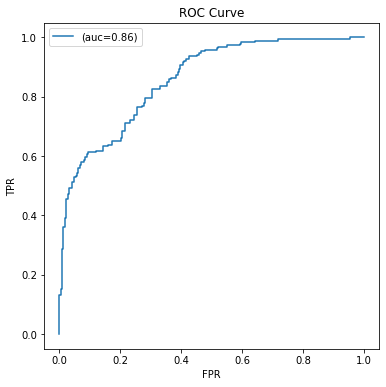

In [24]:
# Plot ROC curve

fpr, tpr,_ = metrics.roc_curve(y_test,predictions_probs[:,1] ,pos_label='Pnemonia')
auc = metrics.roc_auc_score(y_test,predictions_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label='(auc={:3.2f})'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()

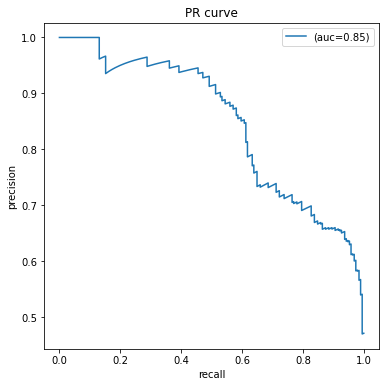

In [25]:
# Plot PR curve

prec, rec, threshs = metrics.precision_recall_curve(y_test,predictions_probs[:,1],pos_label='Pnemonia')
auc = metrics.auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec,prec,label='(auc={:3.2f})'.format(auc))
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("PR curve")
plt.legend()

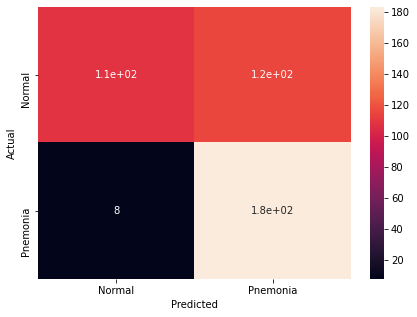

In [26]:
# Plot confusion matrix

data = {"y_test": y_test, "y_hat":predictions}
df = pd.DataFrame(data, columns=["y_test", "y_hat"])
confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
f, ax = plt.subplots(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True)
plt.show()